# Visualize feature contributions in MCSS only scoring using crystal pose

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from glob import glob
sys.path.append('../1_dock')
sys.path.append('../ifp')
sys.path.append('../mcss')
sys.path.append('../3_analyze')
from shared_paths import shared_paths
from density_estimate import DensityEstimate
from containers import Protein

%matplotlib inline

# MCSS for all proteins

In [2]:
indiv_stats = {} # {Protein :  {dist : DensityEstimate}}
counts = {}
for fname in glob("{}/*/stats/stats5/*mcss*".format(shared_paths['data'])):
    protein = fname.replace(shared_paths['data'], '').split('/')[0]
    dist = fname.split('/')[-1].split('-')[-1].split('.')[0]
    de = DensityEstimate.read(fname)
    if protein not in indiv_stats:
        indiv_stats[protein] = {}
        counts[protein] = {}
        
    if dist not in indiv_stats[protein]:
        indiv_stats[protein][dist] = de
        counts[protein][dist] = int(de.fx[0] != de.fx[-1])
        
    else:
        indiv_stats[protein][dist] = indiv_stats[protein][dist].average(de)
        counts[protein][dist] += int(de.fx[0] != de.fx[-1])

In [3]:
print len(counts)

32


In [4]:
for protein, count in counts.items():
    print protein.ljust(10), str(count['native']).ljust(10), str(count['reference']).ljust(10)

P00489     102        120       
PLK1       7          20        
Q16539     5          15        
MGLUR5     0          1         
ERA        43         59        
P07900     27         39        
GLUT1      0          0         
P18031     12         60        
P56817     11         77        
O60885     6          8         
MEK1       46         61        
JAK2       11         27        
P00742     8          13        
DTRANSP    24         24        
P00749     57         57        
P00734     23         44        
P00760     41         66        
B2AR       9          9         
GCR        6          30        
P24941     0          54        
B1AR       21         24        
VITD       139        139       
A2AR       19         39        
SMO        0          0         
P03951     1          39        
Q9Y233     75         106       
CHK1       24         33        
CDK2       17         42        
AR         9          9         
BRAF       13         31        
MR        

In [5]:
# Proteins with no MCSS
count = 0
for protein, dists in indiv_stats.items():
    if dists['native'].fx[0] == dists['native'].fx[-1]:
        print protein
        count += 1
print count
print
count = 0
for protein, dists in indiv_stats.items():
    if dists['reference'].fx[0] ==  dists['reference'].fx[-1]:
        print protein
        count += 1
print count

MGLUR5
GLUT1
P24941
SMO
4

GLUT1
SMO
2


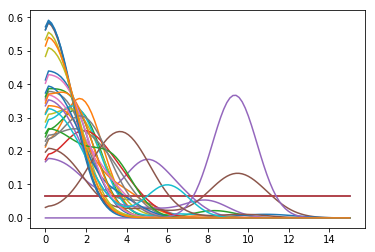

In [6]:
for protein, dists in indiv_stats.items():
    plt.plot(dists['native'].x, dists['native'].fx)

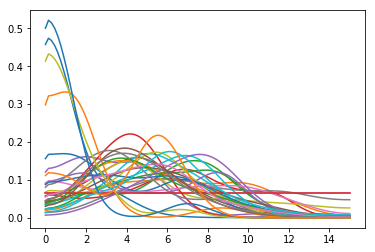

In [7]:
for protein, dists in indiv_stats.items():
    plt.plot(dists['reference'].x, dists['reference'].fx)

P03951


(-10, 10)

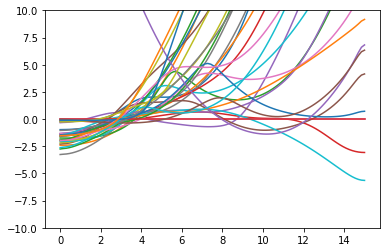

In [8]:
for protein, dists in indiv_stats.items():
    assert all(dists['reference'].x == dists['native'].x)
    plt.plot(dists['reference'].x, np.log(dists['reference'].fx) - np.log(dists['native'].fx))
    if (np.log(dists['reference'].fx) - np.log(dists['native'].fx))[0] > 1:
        print protein
plt.ylim(-10, 10)

# Merging

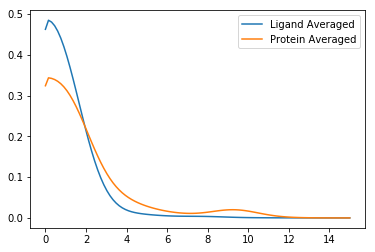

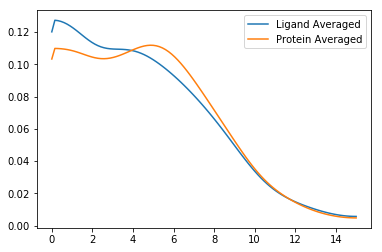

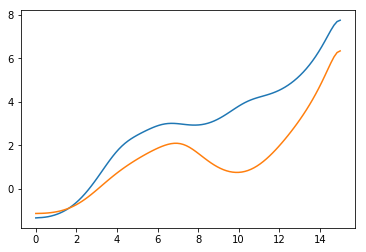

In [16]:
# Weighted by poses
def copy(self):
    de = DensityEstimate()
    de.points = self.points
    de.out_of_bounds = self.out_of_bounds
    de.sd = self.sd
    de.n_samples = self.n_samples
    de.reflect = self.reflect
    de.x = np.copy(self.x)
    de.fx = np.copy(self.fx)
    return de

def compare(dist):
    de1 = None
    for protein, dists in indiv_stats.items():
        if de1 is None:
            de1 = dists[dist]
        else:
            de1 = de1.average(dists[dist])
    plt.plot(de1.x, de1.fx, label = 'Ligand Averaged')

    # Weighted by protein
    de2 = None
    for protein, dists in indiv_stats.items():
        c = copy(dists[dist])
        c.n_samples = min(1, c.n_samples)
        if de2 is None:
            de2 = c
        else:
            de2 = de2.average(c)
    plt.plot(de2.x, de2.fx, label = 'Protein Averaged')
    plt.legend()
    plt.show()
    return de1, de2

native1, native2 = compare('native')
ref1,    ref2    = compare('reference')

plt.plot(native1.x, - np.log(native1.fx) + np.log(ref1.fx), label = 'Ligand Averaged')
plt.plot(native2.x, - np.log(native2.fx) + np.log(ref2.fx), label = 'Protein Averaged')
plt.show()

# MCSS stats used for all proteins

In [10]:
stats = {} # {Protein :  {dist : DensityEstimate}}
for fname in glob("{}/*/scores/pdb_crystal_only_mcss/*.txt".format(shared_paths['data'])):
    protein = fname.replace(shared_paths['data'], '').split('/')[0]
    dist = fname.split('/')[-1].split('_')[0]
    feature = fname.split('/')[-1].split('_')[1].split('.')[0]
    if protein not in stats: stats[protein] = {}
    stats[protein][dist] = DensityEstimate.read(fname)

P00489


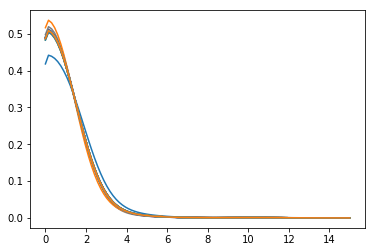

In [11]:
for protein, dists in stats.items():
    plt.plot(dists['native'].x, dists['native'].fx)
    if dists['native'].fx[0] < 0.45: print protein

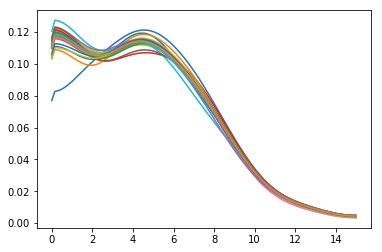

In [12]:
for protein, dists in stats.items():
    plt.plot(dists['reference'].x, dists['reference'].fx)

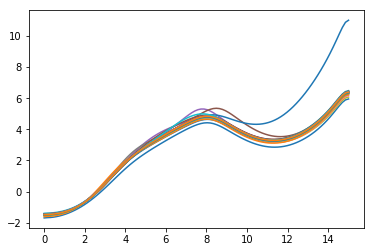

In [13]:
for protein, dists in stats.items():
    assert all(dists['reference'].x == dists['native'].x)
    plt.plot(dists['reference'].x, np.log(dists['reference'].fx) - np.log(dists['native'].fx))

# Breakdown of scoring with crystal poses

In [24]:
from pairs import LigPair

max_ligands = 20
for protein in stats:
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands)
    
    crystal_lig = '{}_crystal_lig'.format(lm.st)
    print prot.load_docking
    prot.load_docking(crystal_lig, load_fp = False, load_crystal = True, load_mcss = True)
    

<bound method Protein.load_docking of <containers.Protein instance at 0x10671b440>>


TypeError: load_docking() got an unexpected keyword argument 'load_crystal'